In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation
from module.utility import show_images, make_segments
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
rose_image_grey = np.array(Image.open('images/rose.jpg').resize((288, 216)).convert('L'))
pins_image_grey = np.array(Image.open('images/clothpins.png').resize((216, 288)).convert('L'))

face1_image_grey = np.array(Image.open('images/face1.jpg').resize((256, 256)).convert('L'))
face2_image_grey = np.array(Image.open('images/face2.jpg').resize((256, 256)).convert('L'))

# Segmentation
Segmentation is the process of separating an image into coherent regions/objects.
This include separating an subject from the background, or decomposing a scene into multiple objects.

## Toy Example

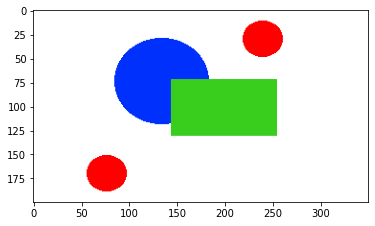

In [3]:
shape_image_rgb = np.array(Image.open('images/shapes.png').convert('RGB'))
plt.imshow(shape_image_rgb);

Suppose we wish to segment the above image into their respective shapes.
As we have established that [intensity carries much of the information in an image](./introduction.ipynb#intensity-vs-colour),
we can use the greyscale image find its corresponding [image histogram](./point_processing.ipynb#image-histogram).

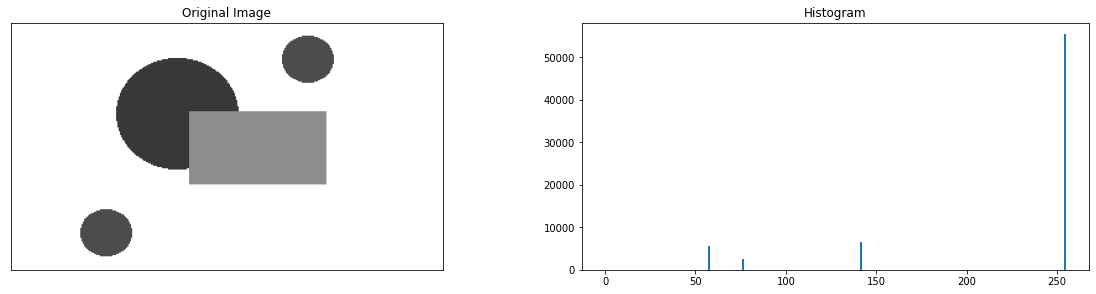

In [4]:
shape_image_grey = np.array(Image.open('images/shapes.png').convert('L'))

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Original Image')
ax11.imshow(shape_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.hist(shape_image_grey.ravel(), bins=range(256));

From this, we can clearly see 4 distinct pixel values, and thus we can easily map each pixel value to an object label.

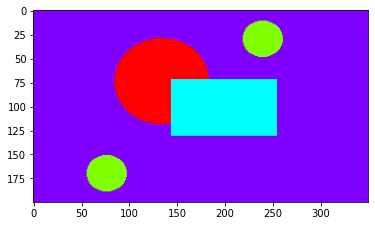

In [5]:
mapping = {intensity: label for label, intensity in enumerate(set(shape_image_grey.ravel()))}
labelled_image = np.vectorize(lambda x: mapping[x])(shape_image_grey)

plt.imshow(make_segments(labelled_image));

(To show the segments, we map each label to different hues in the colour spectrum)

However, images typically are not so easy to segment.
For example, if there is noise in the image, then this segmentation method is insufficient.

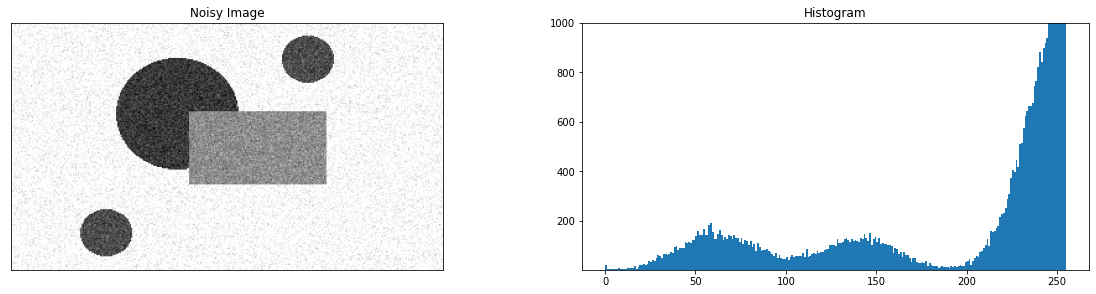

In [6]:
from module.add_noise import gaussian_noise

noisy_image = gaussian_noise(shape_image_grey)

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Noisy Image')
ax11.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.set_ylim(1000)
ax12.invert_yaxis()
ax12.hist(noisy_image.ravel(), bins=range(256));

Now, we cannot find a clear mapping from intensity values to object labels, because the same intensity value may be present in multiple objects, indicated by the overlaps in the curves.

## Clustering
**Clustering** is the act of grouping similar data points, and representing them with a single label.
This is similar to our goal of segmentation.

To perform clustering, we need to determine two factors:

1. Data features
    * We need to represent the pixel as a certain set of features (such as intensity values, RGB values, *etc*)
2. Distance measure
    * We need a method of comparing two pixels for their similarity/distance from each other, using the features we established above

Note that this means that for clustering, we are usually working mainly in the **feature space** of the image, and not the original image itself.
The feature could be a single value (thus 1 dimensional), such as intensity, or multiple values such as each of the RGB channel (thus multi-dimensional).

### K-means clustering


From the histogram, we can see that each peak corresponds to a segment in the original image.
Thus, we wish to find the center of each "hump", such that each of the center can be the representative of the pixels close to it.
Hence, the best cluster centers will minimize the distance between each points and their corresponding centers.

However, notice that we are in a dilemma.
Because to find the correct centers, we need find the group membership of the pixels to compute the mean of the group.
But to find the group membership of the pixels, we need to know the cluster centers to assign each pixel to the closest center.

To resolve this issue, we randomly assign the initial value for the centers.
Then we perform our clustering based on these centers, and continually improve our center values.
Hence, the procedure is as follows:
1. Decide on number of cluster to have
2. Randomly initialize that many cluster centers
3. For each pixel in the feature space, assign it the label corresponding to the center that it is closest to
4. For each label corresponding to a center, compute the new center using the average of the feature values of the pixel assigned to it
5. Repeat 3-5 until convergence

In [7]:
from module.kmeans import *
show_implementation(make_centers)

def make_centers(num_clusters, features):
    feature_maxes = features.max(axis=0).max(axis=0)
    if len(features.shape) == 2:
        feature_maxes = [feature_maxes]
    centers = np.random.rand(num_clusters, len(feature_maxes))
    for i, m in enumerate(feature_maxes):
        centers[:, i] = centers[:, i] * m
        
    return centers


Firstly, we randomize the centers of the clusters.

In [8]:
show_implementation(get_labels)

def get_labels(features, centers):
    num_features = centers.shape[1]
    tree = KDTree(centers)
    _, labels = tree.query(features.reshape((-1, num_features)))
    return labels.reshape(features.shape[:2])


Then, for each pixels, we find the cluster that it is nearest to and assign it that label.

We use `KDTree` in our implementation.
It merely is a data structure that dramatically speeds up the querying for the nearest neighbour.

In [9]:
show_implementation(get_next_centers)

def get_next_centers(curr_centers, features):
    labels = get_labels(features, curr_centers)
    new_centers = np.array([[features[labels==i].mean(axis=0)] for i in range(len(curr_centers))])
    new_centers = new_centers.reshape(curr_centers.shape)
    return new_centers


For each label, we find all the associated pixels and calculate their mean.
These means will be the value for the new centers for the next iteration.

In [10]:
show_implementation(kmeans)

def kmeans(features, num_clusters, initial_centers=None, epsilon=1e-6):
    if initial_centers is None:
        initial_centers = make_centers(num_clusters, features)
    
    centers = initial_centers
    diff = float('infinity')
    while diff > epsilon:
        new_centers = get_next_centers(centers, features)
        diff = ((centers - new_centers)**2).sum()
        centers = new_centers
        
    return get_labels(features, centers), centers


Putting it all together, we get the above.

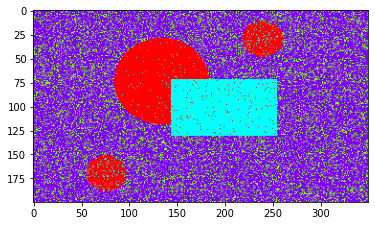

In [11]:
features = noisy_image
num_clusters = 4
initial_centers = make_centers(num_clusters, features)
centers = initial_centers
diff = float('infinity')
prev_centers = []
i = 0
while diff > 1e-6:
    if i % 5 == 0 and diff > 1:
        prev_centers.append(centers)
    i += 1
    new_centers = get_next_centers(centers, features)
    diff = ((centers - new_centers)**2).sum()
    centers = new_centers

labelled_image = get_labels(features, centers)
plt.imshow(make_segments(labelled_image));

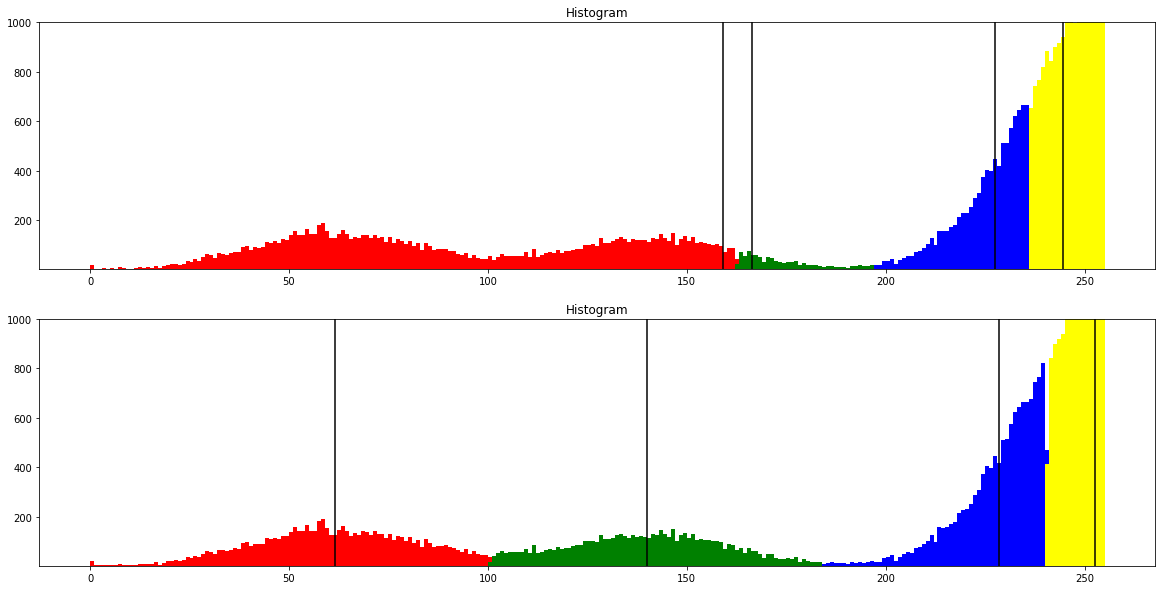

In [12]:
f = plt.figure(figsize=(20,len(prev_centers) * 5))

for i, p_center in enumerate(prev_centers):
    ax = f.add_subplot(len(prev_centers), 1, i+1)    
    ax.title.set_text('Histogram')
    ax.set_ylim(1000)
    ax.invert_yaxis()
    colors = ['red', 'blue', 'green', 'yellow', 'cyan']

    labels = get_labels(noisy_image, p_center)
    for j in range(num_clusters):
        ax.hist(noisy_image[labels == j].ravel(), bins=range(256), color=colors[j])
        ax.axvline(x=p_center[j], color='black');

The dark lines indicates the location of the centers, and each histogram is coloured based on its labeling at that iteration of clustering.
At our final stage, we can see that our centers are approximately at the peak of each density (at least for the green and the red), as we desired.


Notice that the segmentation for the large circle, rectangle and background is done rather well.
However, the small circle is done rather poorly.
Notice that despite there being 4 observed clusters (large circle, small circle, rectangle and background), we failed to assign the large and small circles different labels.
This is because the system assigned the unique label to the noise instead, since the small circle and large circle looks similar in the intensity plot.

One way to resolve this (for this example) is to cluster using 3 features (RGB) instead of 1 (intensity).
Since the small circle is clearly red and thus a different colour from the other segments, it is likely to be its own cluster if we clustered using 3 features.

Hence, consider the below noisy RGB image.

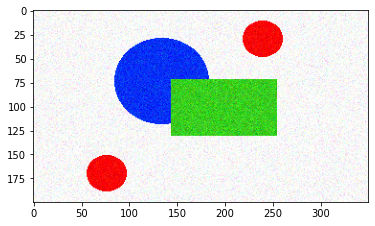

In [13]:
noisy_rgb_image = gaussian_noise(shape_image_rgb)

plt.imshow(noisy_rgb_image/255);

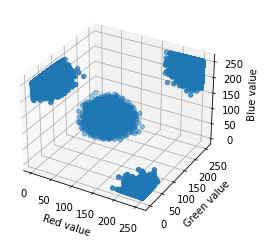

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

red, green, blue = noisy_rgb_image[:,:,0].ravel(), noisy_rgb_image[:,:,1].ravel(), noisy_rgb_image[:,:,2].ravel()

ax.scatter(red, green, blue)

ax.set_xlabel('Red value')
ax.set_ylabel('Green value')
ax.set_zlabel('Blue value')

plt.show()

From the feature space plot, we can clearly see that there are 4 distinct cluster.

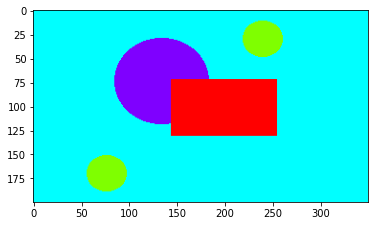

In [15]:
labelled_image, _ = kmeans(noisy_rgb_image, 4)

plt.imshow(make_segments(labelled_image));

Hence, when we cluster using RGB as the feature space, we obtain our desired segmentation.

However, note that both small circles have the same RGB value, and thus are assigned the same label.
Depending on the use case, there might be cases where we wish to assign them different labels.
One example would be if there is an image of many black cats, and we wish to count how many cats there are, thus assigning them different labels will be desirable.

To obtain this, we can augment the feature space with X,Y position of the pixel, such that pixels that are spatially close together is more likely to be in the same cluster.

In [16]:
from module.feature import make_pos_intensity_feature
show_implementation(make_pos_intensity_feature)

def make_pos_intensity_feature(grey_image):
    height, width = grey_image.shape
    result = np.zeros((height, width, 3))
    ys = np.tile(np.arange(height), (width, 1)).transpose()
    xs = np.tile(np.arange(width), (height, 1))
    result[:,:,0] = ys / (height - 1)
    result[:,:,1] = xs / (width - 1) 
    result[:,:,2] = grey_image / 255
    
    return result


In [17]:
pos_intensity_features = make_pos_intensity_feature(noisy_image)

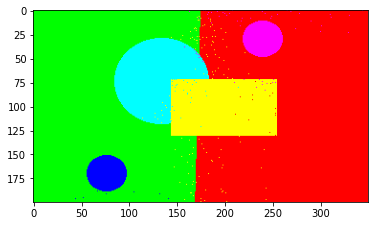

In [18]:
cherrypicked_centers = np.array([[0.81454229, 0.93203773, 0.89036248],
     [0.49040734, 0.37388642, 0.45842976],
     [0.28483854, 0.06676668, 0.88972301],
     [0.38108386, 0.02912938, 0.38201858],
     [0.74009468, 0.52595419, 0.08852695],
     [0.32599047, 0.39735845, 0.08549316],])

labelled_image, _ = kmeans(pos_intensity_features, 6, cherrypicked_centers)

plt.imshow(make_segments(labelled_image));

Hence, we obtain our desired segmentation as aboves.
Note that the above result is heavily cherrypicked, because k-means clustering often fall into local minimums.
Thus, the end results is heavily dependent on the starting centers.
Also, we used 6 clusters instead of 5 in order to assign more clusters (2 clusters) to the background for stability in the clustering algorithm.

Since we know that we cluster better on RGB (for this particular image), we can actually cluster on the feature space where it is RGB with X,Y position, given us a 5 dimensional feature space.

In [19]:
from module.feature import make_pos_rgb_feature
show_implementation(make_pos_rgb_feature)

def make_pos_rgb_feature(rgb_image):
    height, width = rgb_image.shape[:2]
    result = np.zeros((height, width, 5))
    ys = np.tile(np.arange(height), (width, 1)).transpose()
    xs = np.tile(np.arange(width), (height, 1))
    result[:,:,0] = ys / (height - 1)
    result[:,:,1] = xs / (width - 1) 
    result[:,:,2:5] = rgb_image / 255
    
    return result


In [20]:
pos_rgb_features = make_pos_rgb_feature(noisy_rgb_image)

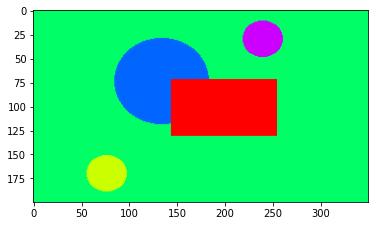

In [21]:
cherry_picked_centers = np.array([[0.38213772, 0.92051223, 0.01227749, 0.58824409, 0.14370663],
 [0.97616429, 0.72606071, 0.02733823, 0.25520947, 0.32510962],
 [0.55341874, 0.73707228, 0.40272165, 0.7276749,  0.83302242],
 [0.2364451,  0.08686595, 0.51767232, 0.19452098, 0.81166719],
 [0.21478713, 0.86601531, 0.97026088, 0.06564897, 0.30432702]])

labelled_image, _ = kmeans(pos_rgb_features, 5, cherry_picked_centers)

plt.imshow(make_segments(labelled_image));

Pros
• Simple, fast to compute
• Converges to local minimum of 
within-cluster squared error
Cons/issues
• Setting k?
• Sensitive to initial centers
• Sensitive to outliers
• Detects spherical clusters
• Assumes means can be computed 
(efficient, meaningful)

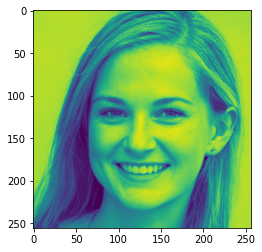

In [28]:
plt.imshow(face1_image_grey)